# Analysis on Convective Clouds in the Maritime Continent

Keely Perry

##### The supporting code for the EOSC 440 Final Project. 

The models used in this project are MIROC6 and SAM0-UNICON. 

In [1]:
# imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import nc_time_axis
import intake
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

## Functions

In [2]:
# Function to load data
def load_data(dataframe):
    # get the path to a specific zarr store (the first one from the dataframe above)
    zstore = dataframe.zstore.values[-1]
    print(zstore)

    # create a mutable-mapping-style interface to the store
    mapper = fsspec.get_mapper(zstore)

    # open it using xarray and zarr
    ds = xr.open_zarr(mapper, consolidated=True)
    return ds

def data_array(dataset, var_id, **kwargs):
    # Regrid longitude to [-180, 180]
    ds_180 = dataset.assign_coords(lon=(((dataset.lon + 180) % 360) - 180)).sortby('lon')

    # Create Xarray DataArray
    if 'var_id' in kwargs:
        da = ds_180[kwargs['var_id']]
    else:
        da = ds_180[var_id]

    # Collect data for Maritime Continent region and years of interest
    da = da.sel(lon = slice(91, 147), lat = slice(-14.6, 19.7), time = slice('1985', '2010'))

    return da

def convert_pr_units(dataarray):
    # Convert precipitation units from kg m-2 s-1 to mm year-1
    da = dataarray * (86400 * 365)
    da = da.assign_attrs(da.attrs)
    da.attrs['units'] = 'mm year-1'
    
    return da

## Load in the CMIP6 Cloud Storage

In [3]:
# Load in data
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cmipdf = col.df

## Convection Depth

The convection depth of the clouds will be found by subtracting the air pressure at the convective cloud tops (cct) by the air pressure at the convective cloud bottoms (ccb). 

The units will be converted from Pa to hPa.

__Conversion example:__

15 Pa = 15 × 0.01 hPa = 0.15 hPa

In [4]:
# Filter for scenario
# cct
miroc_cct_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'cct' & experiment_id == 'historical' & source_id == 'MIROC6'")
sam_cct_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'cct' & experiment_id == 'historical' & source_id == 'SAM0-UNICON'")

# ccb
miroc_ccb_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ccb' & experiment_id == 'historical' & source_id == 'MIROC6'")
sam_ccb_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'ccb' & experiment_id == 'historical' & source_id == 'SAM0-UNICON'")


In [5]:
# Load the data and refine variables into Xarray Data Array

# MIROC6 Model
miroc_cct_df = load_data(miroc_cct_ds)
miroc_cct = data_array(miroc_cct_df, 'cct')

miroc_ccb_df = load_data(miroc_ccb_ds)
miroc_ccb = data_array(miroc_ccb_df, 'ccb')

# SAM0-UNICON Model
sam_cct_df = load_data(sam_cct_ds)
sam_cct = data_array(sam_cct_df, 'cct')

sam_ccb_df = load_data(sam_ccb_ds)
sam_ccb = data_array(sam_ccb_df, 'ccb')

gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/cct/gn/v20190311/
gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/Amon/ccb/gn/v20190311/
gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/Amon/cct/gn/v20190323/
gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/Amon/ccb/gn/v20190323/


In [6]:
# filter for months

## cct
# DJF
miroc_cct_djf = miroc_cct.sel(time=miroc_cct['time'].dt.month.isin([12, 1, 2]))
sam_cct_djf = sam_cct.sel(time=sam_cct['time'].dt.month.isin([12, 1, 2]))

# JJA
miroc_cct_jja = miroc_cct.sel(time=miroc_cct['time'].dt.month.isin([6, 7, 8]))
sam_cct_jja = sam_cct.sel(time=sam_cct['time'].dt.month.isin([6, 7, 8]))

## ccb
# DJF
miroc_ccb_djf = miroc_ccb.sel(time=miroc_ccb['time'].dt.month.isin([12, 1, 2]))
sam_ccb_djf = sam_ccb.sel(time=sam_ccb['time'].dt.month.isin([12, 1, 2]))

# JJA
miroc_ccb_jja = miroc_ccb.sel(time=miroc_ccb['time'].dt.month.isin([6, 7, 8]))
sam_ccb_jja = sam_ccb.sel(time=sam_ccb['time'].dt.month.isin([6, 7, 8]))



In [7]:
# Average over all years and convert units to hPa
# cct
ave_miroc_cct_djf = miroc_cct_djf.mean(dim='time') * 0.01
ave_miroc_cct_jja = miroc_cct_jja.mean(dim='time') * 0.01

ave_sam_cct_djf = sam_cct_djf.mean(dim='time') * 0.01
ave_sam_cct_jja = sam_cct_jja.mean(dim='time') * 0.01

# ccb
ave_miroc_ccb_djf = miroc_ccb_djf.mean(dim='time') * 0.01
ave_miroc_ccb_jja = miroc_ccb_jja.mean(dim='time') * 0.01

ave_sam_ccb_djf = sam_ccb_djf.mean(dim='time') * 0.01
ave_sam_ccb_jja = sam_ccb_jja.mean(dim='time') * 0.01

In [8]:
# Find convection pressure depth for each season
# difference in air pressure = Bottom - Top 

# Change in air pressure during winter
miroc_wint_ave = ave_miroc_ccb_djf - ave_miroc_cct_djf
sam_wint_ave = ave_sam_ccb_djf - ave_sam_cct_djf

# Change in air pressure during summer
miroc_sum_ave = ave_miroc_ccb_jja - ave_miroc_cct_jja
sam_sum_ave = ave_sam_ccb_jja - ave_sam_cct_jja

### Plot the Convective Cloud Depth

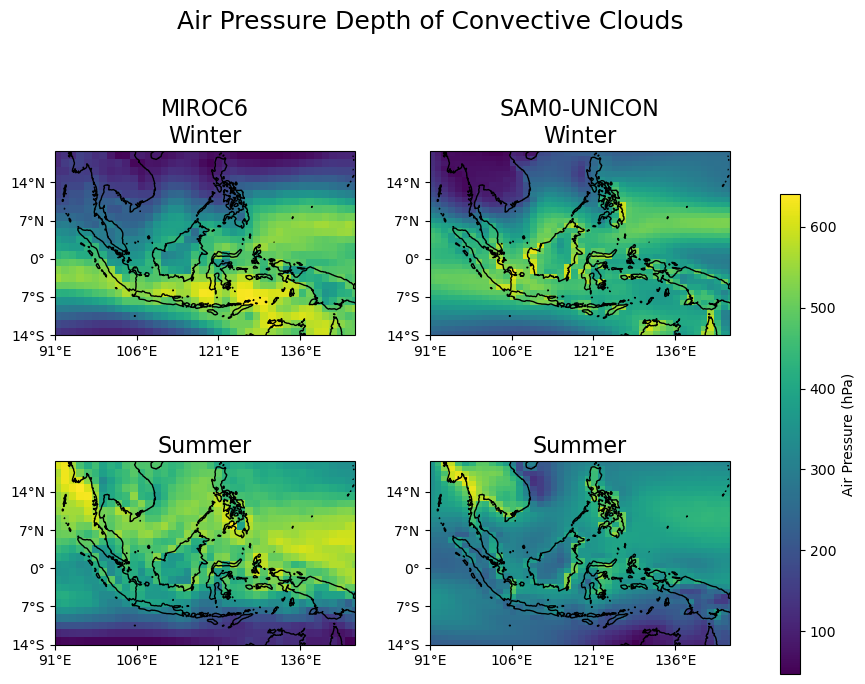

In [9]:
nrows = 2
ncols = 2

models = [miroc_wint_ave, sam_wint_ave, miroc_sum_ave, sam_sum_ave]
names = ['MIROC6\nWinter', 'SAM0-UNICON\nWinter', 'Summer', 'Summer']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='viridis',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize=16)
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([91, 146, -14, 19.7], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(91, 146, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(-14, 19.7, 7), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# set plot title
plt.suptitle("Air Pressure Depth of Convective Clouds", fontsize=18)

#Set colourbar
fig.subplots_adjust(right = 0.8, wspace = 0.25, hspace = 0.01) # plot spacing & placement
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6]) # cbar placement
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Air Pressure (hPa)')

### Plot Air Pressure at Convective Cloud Tops

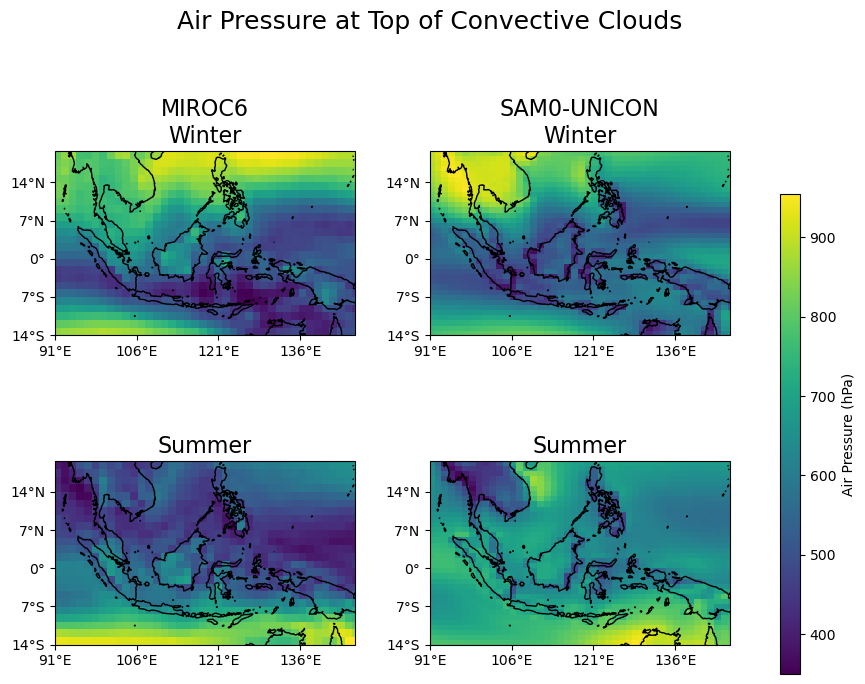

In [10]:
nrows = 2
ncols = 2

models = [ave_miroc_cct_djf, ave_sam_cct_djf, ave_miroc_cct_jja, ave_sam_cct_jja]
names = ['MIROC6\nWinter', 'SAM0-UNICON\nWinter', 'Summer', 'Summer']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='viridis',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize=16)
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([91, 146, -14, 19.7], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(91, 146, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(-14, 19.7, 7), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# set plot title
plt.suptitle("Air Pressure at Top of Convective Clouds", fontsize=18)

#Set colourbar
fig.subplots_adjust(right = 0.8, wspace = 0.25, hspace = 0.01) 
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6])
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Air Pressure (hPa)')

## Convective Precipitation

In [11]:
# Filter for scenario
miroc_prc_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'prc' & experiment_id == 'historical' & source_id == 'MIROC6'")
sam_prc_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'prc' & experiment_id == 'historical' & source_id == 'SAM0-UNICON'")


In [12]:
# Load the data, refine variables into Xarray Data Array, and covert precipitation units

# MIROC6 Model
miroc_prc_df = load_data(miroc_prc_ds)
miroc_prc = data_array(miroc_prc_df, 'prc')
miroc_prc = convert_pr_units(miroc_prc)

# SAM0-UNICON
sam_prc_df = load_data(sam_prc_ds)
sam_prc = data_array(sam_prc_df, 'prc')
sam_prc = convert_pr_units(sam_prc)

gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r16i1p1f1/Amon/prc/gn/v20200519/
gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/Amon/prc/gn/v20190323/


In [13]:
# Filter for seasons and average over time
miroc_prc_djf = miroc_prc.sel(time=miroc_prc['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
miroc_prc_jja = miroc_prc.sel(time=miroc_prc['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

sam_prc_djf = sam_prc.sel(time=sam_prc['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
sam_prc_jja = sam_prc.sel(time=miroc_prc['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

### Plot Historical Convective Precipitation

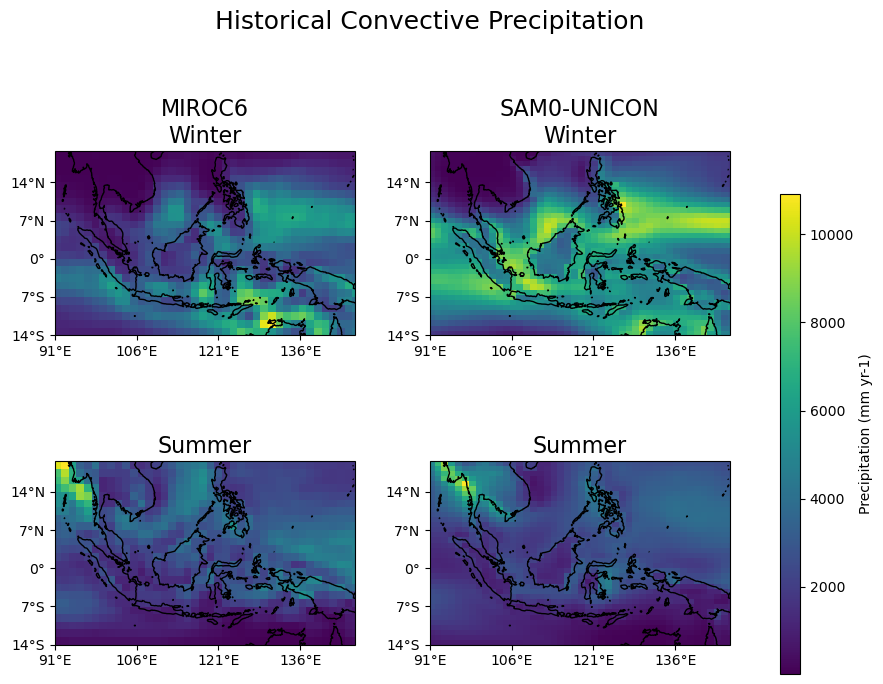

In [14]:
nrows = 2
ncols = 2

models = [miroc_prc_djf, sam_prc_djf, miroc_prc_jja, sam_prc_jja]
names = ['MIROC6\nWinter', 'SAM0-UNICON\nWinter', 'Summer', 'Summer']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='viridis',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize=16)
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([91, 146, -14, 19.7], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(91, 146, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(-14, 19.7, 7), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# set plot title
plt.suptitle("Historical Convective Precipitation", fontsize=18)

#Set colourbar
fig.subplots_adjust(right = 0.8, wspace = 0.25, hspace = 0.01) # plot spacing & placement
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6]) # cbar placement
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Precipitation (mm yr-1)')

## TOA Outgoing Longwave Radiation

In [15]:
# Collect data from CMIP6 Model
miroc_rlut_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'historical' & source_id == 'MIROC6'")
sam_rlut_ds = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlut' & experiment_id == 'historical' & source_id == 'SAM0-UNICON'")


In [16]:
# Load and refine data into Xarray DataArray

# MIROC6
miroc_rlut_df = load_data(miroc_rlut_ds)
miroc_rlut = data_array(miroc_rlut_df, 'rlut')

# SAM0-UNICON
sam_rlut_df = load_data(sam_rlut_ds)
sam_rlut = data_array(sam_rlut_df, 'rlut')

gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r16i1p1f1/Amon/rlut/gn/v20200519/
gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/Amon/rlut/gn/v20190323/


In [17]:
# Filter for seasons and average over time

# Winter
miroc_rlut_djf = miroc_rlut.sel(time=miroc_rlut['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
sam_rlut_djf = sam_rlut.sel(time=sam_rlut['time'].dt.month.isin([12, 1, 2])).mean(dim='time')

# Summer
miroc_rlut_jja = miroc_rlut.sel(time=miroc_rlut['time'].dt.month.isin([6, 7, 8])).mean(dim='time')
sam_rlut_jja = sam_rlut.sel(time=sam_rlut['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

### Plot TOA Outgoing Longwave Radiation

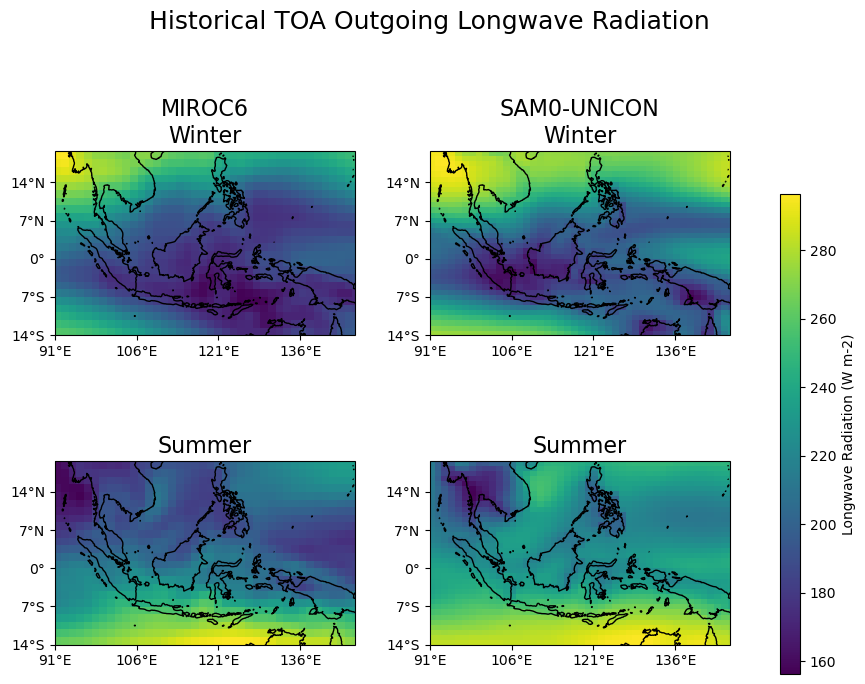

In [18]:
nrows = 2
ncols = 2

models = [miroc_rlut_djf, sam_rlut_djf, miroc_rlut_jja, sam_rlut_jja]
names = ['MIROC6\nWinter', 'SAM0-UNICON\nWinter', 'Summer', 'Summer']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='viridis',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize=16)
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([91, 146, -14, 19.7], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(91, 146, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(-14, 19.7, 7), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# set plot title
plt.suptitle("Historical TOA Outgoing Longwave Radiation", fontsize=18)

#Set colourbar
fig.subplots_adjust(right = 0.8, wspace = 0.25, hspace = 0.01) 
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6]) 
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Longwave Radiation (W m-2)')

## Greenhouse Effect

Proxy for GHE = rlutcs - rlut = TOA outgoing longwave radiation in a clear-sky - TOA outgoing longwave radiation 


In [19]:
# TOA Outgoing LW Radiation in a clear-sky scenario
miroc_rlutcs_df = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id == 'historical' & source_id == 'MIROC6'")
sam_rlutcs_df = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rlutcs' & experiment_id == 'historical' & source_id == 'SAM0-UNICON'")


In [20]:
# Load the clear-sky TOA outgoing longwave radiation
miroc_rlutcs_ds = load_data(miroc_rlutcs_df)
miroc_rlutcs = data_array(miroc_rlutcs_ds, 'rlutcs')

sam_rlutcs_ds = load_data(sam_rlutcs_df)
sam_rlutcs = data_array(sam_rlutcs_ds, 'rlutcs')

gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r3i1p1f1/Amon/rlutcs/gn/v20190311/
gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/Amon/rlutcs/gn/v20190323/


In [21]:
# Find Greenhouse effect
ghe_miroc = miroc_rlutcs - miroc_rlut
ghe_sam = sam_rlutcs - sam_rlut

In [22]:
# Filter for seasons
GHE_miroc_djf = ghe_miroc.sel(time=ghe_miroc['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
GHE_miroc_jja = ghe_miroc.sel(time=ghe_miroc['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

GHE_sam_djf = ghe_sam.sel(time=ghe_sam['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
GHE_sam_jja = ghe_sam.sel(time=ghe_sam['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

### Plot Greenhouse Effect

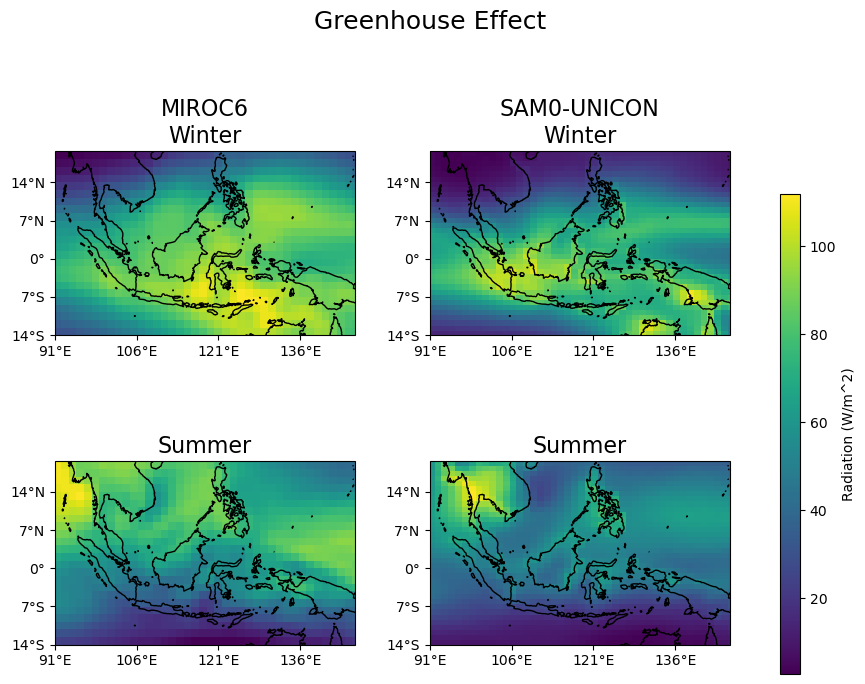

In [23]:
nrows = 2
ncols = 2

models = [GHE_miroc_djf, GHE_sam_djf, GHE_miroc_jja, GHE_sam_jja]
names = ['MIROC6\nWinter', 'SAM0-UNICON\nWinter', 'Summer', 'Summer']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='viridis',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize=16)
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([91, 146, -14, 19.7], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(91, 146, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(-14, 19.7, 7), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# set plot title
plt.suptitle("Greenhouse Effect", fontsize=18)

#Set colourbar
fig.subplots_adjust(right = 0.8, wspace = 0.25, hspace = 0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6]) 
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Radiation (W/m^2)')

## Net Radiative Effect

We already have the TOA outgoing longwave radiation data, so we only need to retrieve the shortwave radiation data.

In [24]:
# Retrieve the outgoing shortwave data
miroc_rsut_df = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'historical' & source_id == 'MIROC6'")
sam_rsut_df = cmipdf.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'rsut' & experiment_id == 'historical' & source_id == 'SAM0-UNICON'")


In [25]:
miroc_rsut_ds = load_data(miroc_rsut_df)
miroc_rsut = data_array(miroc_rsut_ds, 'rsut')

sam_rsut_ds = load_data(sam_rsut_df)
sam_rsut = data_array(sam_rsut_ds, 'rsut')

gs://cmip6/CMIP6/CMIP/MIROC/MIROC6/historical/r20i1p1f1/Amon/rsut/gn/v20200519/
gs://cmip6/CMIP6/CMIP/SNU/SAM0-UNICON/historical/r1i1p1f1/Amon/rsut/gn/v20190323/


##### Net Radiation = Incoming_SW − Outgoing_SW − Outgoing_LW

Since there is no incoming shortwave radiation in the models, the solar constant will be used. 

Solar Constant = 1367 W m-2

In [26]:
# Use the solar constant here
net_miroc = 1367 - miroc_rsut - miroc_rlut
net_sam = 1367 - sam_rsut - sam_rlut

In [27]:
# Filter for seasons 
net_miroc_djf = net_miroc.sel(time=net_miroc['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
net_miroc_jja = net_miroc.sel(time=net_miroc['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

net_sam_djf = net_sam.sel(time=net_sam['time'].dt.month.isin([12, 1, 2])).mean(dim='time')
net_sam_jja = net_sam.sel(time=net_sam['time'].dt.month.isin([6, 7, 8])).mean(dim='time')

### Plot the Net Radiative Effect

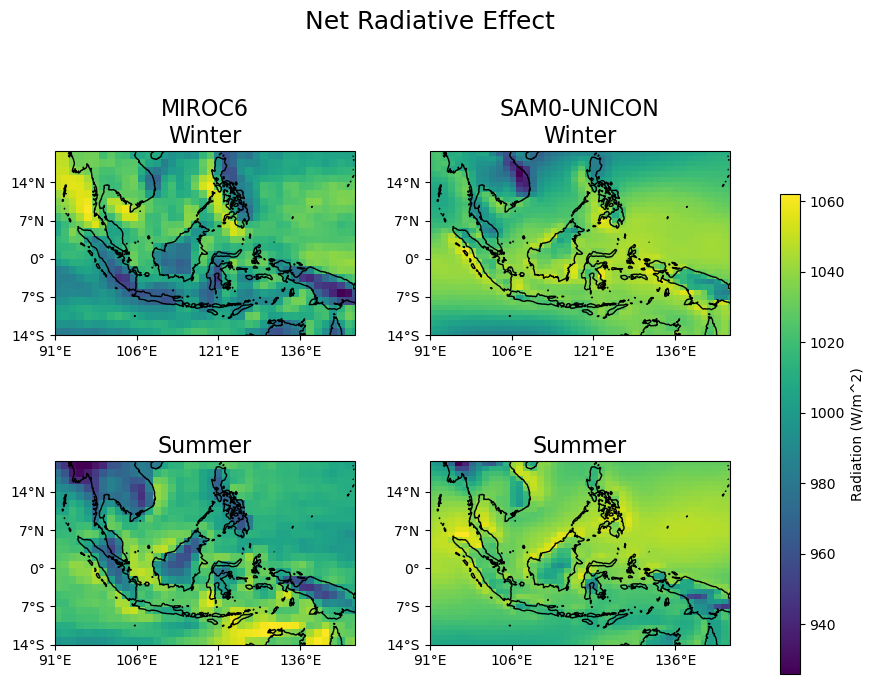

In [28]:
nrows = 2
ncols = 2

models = [net_miroc_djf, net_sam_djf, net_miroc_jja, net_sam_jja]
names = ['MIROC6\nWinter', 'SAM0-UNICON\nWinter', 'Summer', 'Summer']

# Set up figure
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                       figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

#Loop over all of the models
for i,m in enumerate(models):
    cs = m.plot(ax=axs[i], transform=ccrs.PlateCarree(), cmap='viridis',add_colorbar=False)
    
    # Title each subplot with the name of the model
    axs[i].set_title(names[i], fontsize=16)
    
    # Draw the coastines for each subplot
    axs[i].coastlines()

    # Set extent for maps
    axs[i].set_extent([91, 146, -14, 19.7], crs=ccrs.PlateCarree())

    #Set Longitude Label
    axs[i].set_xticks(np.arange(91, 146, 15), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)
    axs[i].xaxis.label.set_visible(False)

    #Set Latitude Label
    axs[i].set_yticks(np.arange(-14, 19.7, 7), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    axs[i].yaxis.label.set_visible(False)

# set plot title
plt.suptitle("Net Radiative Effect", fontsize=18)

#Set colourbar
fig.subplots_adjust(right = 0.8, wspace = 0.25, hspace = 0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.6]) 
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='vertical', label = 'Radiation (W/m^2)')